In [216]:
import sqlite3
import pandas as pd
import numpy as np
import pytz
from scipy import stats
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [217]:
db_file = '/Users/brandonshimiaie/Projects/pyInvest/sqlite/db/stock.db'
conn = sqlite3.connect(db_file)

In [379]:
ticker = 'AAPL'
hist_vlm_trading_days = 22
hist_volatility_trading_days = 22
percentile_thresh = 20

backtest_start_buffer_days = 730

trade_start_hour = 14
trade_exit_end_hour = 11

req_volume_ratio = 1.4

In [219]:
query = f"""
SELECT * FROM BARS
WHERE TICKER = '{ticker}'
"""
df = pd.read_sql_query(query, conn)
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df['DATE'] = pd.to_datetime(df['DATE'])
df['VOLUME'] = df['VOLUME'] * df['VWAP']
df

,TICKER,DATETIME,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,TRADECOUNT,VWAP
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.15,27.100,27.1100,5.401637e+07,1236,27.130000
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.13,27.080,27.1200,1.897787e+07,1172,27.110000
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.12,27.070,27.0900,2.020470e+07,947,27.090000
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.09,27.060,27.0600,2.104127e+07,890,27.080000
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.07,27.050,27.0500,1.613166e+07,846,27.060000
...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.18,151.820,152.1400,7.863522e+07,5707,152.022325
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.36,152.115,152.3000,4.978513e+07,3521,152.228098
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.52,152.250,152.4450,5.964870e+07,4078,152.403386
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.61,152.420,152.5778,7.195375e+07,4085,152.542623


In [220]:
df['dayCumVolume'] = df.groupby('DATE')['VOLUME'].cumsum()
day_tot_volume = df.groupby('DATE')['VOLUME'].sum().reset_index()
day_tot_volume = day_tot_volume.rename(columns={
    'VOLUME': 'dayTotVolume'
})
df = df.merge(day_tot_volume, on=['DATE'], how='left')
df['pctDayVolume'] = df['dayCumVolume']/df['dayTotVolume']
df

,TICKER,DATETIME,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,TRADECOUNT,VWAP,dayCumVolume,dayTotVolume,pctDayVolume
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.15,27.100,27.1100,5.401637e+07,1236,27.130000,5.401637e+07,3.415319e+09,0.015816
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.13,27.080,27.1200,1.897787e+07,1172,27.110000,7.299424e+07,3.415319e+09,0.021373
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.12,27.070,27.0900,2.020470e+07,947,27.090000,9.319894e+07,3.415319e+09,0.027289
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.09,27.060,27.0600,2.104127e+07,890,27.080000,1.142402e+08,3.415319e+09,0.033449
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.07,27.050,27.0500,1.613166e+07,846,27.060000,1.303719e+08,3.415319e+09,0.038173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.18,151.820,152.1400,7.863522e+07,5707,152.022325,9.166291e+09,9.602318e+09,0.954591
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.36,152.115,152.3000,4.978513e+07,3521,152.228098,9.216076e+09,9.602318e+09,0.959776
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.52,152.250,152.4450,5.964870e+07,4078,152.403386,9.275725e+09,9.602318e+09,0.965988
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.61,152.420,152.5778,7.195375e+07,4085,152.542623,9.347678e+09,9.602318e+09,0.973481


In [221]:
df['time'] = df['DATETIME'].apply(lambda x: x.strftime('%H:%M:%S'))
hist_pct_volume = df.groupby('time')['pctDayVolume'].expanding().mean().reset_index().set_index('level_1').sort_index().groupby('time').shift()
hist_pct_volume = hist_pct_volume.rename(columns={
    'pctDayVolume': 'histPctDayVolume'
})
df = df.merge(hist_pct_volume, left_index=True, right_index=True, how='left')
df['estDayVolume'] = df['dayCumVolume']/df['histPctDayVolume']
df

,TICKER,DATETIME,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,TRADECOUNT,VWAP,dayCumVolume,dayTotVolume,pctDayVolume,time,histPctDayVolume,estDayVolume
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.15,27.100,27.1100,5.401637e+07,1236,27.130000,5.401637e+07,3.415319e+09,0.015816,09:30:00,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.13,27.080,27.1200,1.897787e+07,1172,27.110000,7.299424e+07,3.415319e+09,0.021373,09:31:00,NaN,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.12,27.070,27.0900,2.020470e+07,947,27.090000,9.319894e+07,3.415319e+09,0.027289,09:32:00,NaN,NaN
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.09,27.060,27.0600,2.104127e+07,890,27.080000,1.142402e+08,3.415319e+09,0.033449,09:33:00,NaN,NaN
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.07,27.050,27.0500,1.613166e+07,846,27.060000,1.303719e+08,3.415319e+09,0.038173,09:34:00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.18,151.820,152.1400,7.863522e+07,5707,152.022325,9.166291e+09,9.602318e+09,0.954591,15:55:00,0.962878,9.519678e+09
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.36,152.115,152.3000,4.978513e+07,3521,152.228098,9.216076e+09,9.602318e+09,0.959776,15:56:00,0.968443,9.516387e+09
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.52,152.250,152.4450,5.964870e+07,4078,152.403386,9.275725e+09,9.602318e+09,0.965988,15:57:00,0.974561,9.517854e+09
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.61,152.420,152.5778,7.195375e+07,4085,152.542623,9.347678e+09,9.602318e+09,0.973481,15:58:00,0.982053,9.518505e+09


In [222]:
hist_day_volume = day_tot_volume.set_index('DATE')['dayTotVolume'].rolling(hist_vlm_trading_days).mean().shift().reset_index().dropna()
hist_day_volume = hist_day_volume.rename(columns={
    'dayTotVolume': 'histDayVolume'
})
df = df.merge(hist_day_volume, on=['DATE'], how='left')
df['todayVsHistVolume'] = df['estDayVolume']/df['histDayVolume']
df

,TICKER,DATETIME,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,TRADECOUNT,VWAP,dayCumVolume,dayTotVolume,pctDayVolume,time,histPctDayVolume,estDayVolume,histDayVolume,todayVsHistVolume
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.15,27.100,27.1100,5.401637e+07,1236,27.130000,5.401637e+07,3.415319e+09,0.015816,09:30:00,NaN,NaN,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.13,27.080,27.1200,1.897787e+07,1172,27.110000,7.299424e+07,3.415319e+09,0.021373,09:31:00,NaN,NaN,NaN,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.12,27.070,27.0900,2.020470e+07,947,27.090000,9.319894e+07,3.415319e+09,0.027289,09:32:00,NaN,NaN,NaN,NaN
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.09,27.060,27.0600,2.104127e+07,890,27.080000,1.142402e+08,3.415319e+09,0.033449,09:33:00,NaN,NaN,NaN,NaN
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.07,27.050,27.0500,1.613166e+07,846,27.060000,1.303719e+08,3.415319e+09,0.038173,09:34:00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.18,151.820,152.1400,7.863522e+07,5707,152.022325,9.166291e+09,9.602318e+09,0.954591,15:55:00,0.962878,9.519678e+09,7.600539e+09,1.252500
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.36,152.115,152.3000,4.978513e+07,3521,152.228098,9.216076e+09,9.602318e+09,0.959776,15:56:00,0.968443,9.516387e+09,7.600539e+09,1.252067
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.52,152.250,152.4450,5.964870e+07,4078,152.403386,9.275725e+09,9.602318e+09,0.965988,15:57:00,0.974561,9.517854e+09,7.600539e+09,1.252260
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.61,152.420,152.5778,7.195375e+07,4085,152.542623,9.347678e+09,9.602318e+09,0.973481,15:58:00,0.982053,9.518505e+09,7.600539e+09,1.252346


In [223]:
price_df = df[['TICKER', 'DATETIME', 'DATE', 'OPEN', 'CLOSE', 'HIGH', 'LOW']]
price_df

,TICKER,DATETIME,DATE,OPEN,CLOSE,HIGH,LOW
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.1100,27.15,27.100
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.1200,27.13,27.080
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.0900,27.12,27.070
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.0600,27.09,27.060
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.0500,27.07,27.050
...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.1400,152.18,151.820
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.3000,152.36,152.115
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.4450,152.52,152.250
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.5778,152.61,152.420


In [226]:
def _percentile(n):
    def _percentile_h(x):
        return np.percentile(x, n)
    _percentile_h.__name__ = 'percentile_%s' % n
    return _percentile_h

def _last(x):
    return x.iloc[-1]

percentiles = price_df.groupby('DATE').agg(
    day_upper_20=('CLOSE', _percentile(100-percentile_thresh)),
    day_lower_20=('CLOSE', _percentile(percentile_thresh)),
    day_close=('CLOSE', _last),
).reset_index()

percentiles['finish_above_20'] = percentiles['day_close'] > percentiles['day_upper_20']
percentiles['finish_below_20'] = percentiles['day_close'] < percentiles['day_lower_20']

price_df = price_df.merge(percentiles, on=['DATE'], how='left')
price_df

,TICKER,DATETIME,DATE,OPEN,CLOSE,HIGH,LOW,day_upper_20,day_lower_20,day_close,finish_above_20,finish_below_20
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.1100,27.15,27.100,27.030,26.79,26.81,False,False
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.1200,27.13,27.080,27.030,26.79,26.81,False,False
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.0900,27.12,27.070,27.030,26.79,26.81,False,False
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.0600,27.09,27.060,27.030,26.79,26.81,False,False
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.0500,27.07,27.050,27.030,26.79,26.81,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.1400,152.18,151.820,152.304,150.81,152.99,True,False
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.3000,152.36,152.115,152.304,150.81,152.99,True,False
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.4450,152.52,152.250,152.304,150.81,152.99,True,False
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.5778,152.61,152.420,152.304,150.81,152.99,True,False


In [227]:
tz = pytz.timezone('US/Eastern')
price_df['close_time'] = price_df['DATE'].apply(lambda x: pd.Timestamp(f"{x} 16:00:00", tz=tz))
price_df['minutes_to_close'] = (price_df['close_time']-price_df['DATETIME']).astype('timedelta64[m]')
price_df

,TICKER,DATETIME,DATE,OPEN,CLOSE,HIGH,LOW,day_upper_20,day_lower_20,day_close,finish_above_20,finish_below_20,close_time,minutes_to_close
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.1100,27.15,27.100,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,390.0
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.1200,27.13,27.080,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,389.0
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.0900,27.12,27.070,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,388.0
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.0600,27.09,27.060,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,387.0
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.0500,27.07,27.050,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.1400,152.18,151.820,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,5.0
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.3000,152.36,152.115,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,4.0
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.4450,152.52,152.250,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,3.0
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.5778,152.61,152.420,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,2.0


In [228]:
def get_percentile_of_score(x):
    if len(x) == 0:
        return np.nan
    return stats.percentileofscore(x, x.iloc[-1])

price_percentile = price_df.groupby('DATE')['CLOSE'].expanding().apply(lambda x: get_percentile_of_score(x)).reset_index()
price_percentile = price_percentile.set_index('level_1')
price_percentile = price_percentile.rename(columns={
    'CLOSE': 'current_price_percentile'
})
price_percentile = price_percentile.drop(columns=['DATE'])

price_df = price_df.merge(price_percentile, left_index=True, right_index=True, how='left')
price_df

,TICKER,DATETIME,DATE,OPEN,CLOSE,HIGH,LOW,day_upper_20,day_lower_20,day_close,finish_above_20,finish_below_20,close_time,minutes_to_close,current_price_percentile
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.1100,27.15,27.100,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,390.0,100.000000
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.1200,27.13,27.080,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,389.0,100.000000
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.0900,27.12,27.070,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,388.0,33.333333
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.0600,27.09,27.060,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,387.0,25.000000
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.0500,27.07,27.050,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,386.0,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.1400,152.18,151.820,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,5.0,77.849741
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.3000,152.36,152.115,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,4.0,80.620155
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.4450,152.52,152.250,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,3.0,81.958763
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.5778,152.61,152.420,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,2.0,85.861183


In [229]:
open_price = price_df.groupby('DATE')['OPEN'].first().reset_index()
open_price = open_price.rename(columns={
    'OPEN': 'day_open'
})
price_df = price_df.merge(open_price, on=['DATE'], how='left')
price_df['current_return'] = (price_df['CLOSE'] - price_df['day_open'])/price_df['day_open']

expanding_high = price_df.groupby('DATE')['HIGH'].expanding().max().shift().reset_index()
expanding_high = expanding_high.set_index('level_1')
expanding_high = expanding_high.rename(columns={
    'HIGH': 'current_high'
})
expanding_high = expanding_high.drop(columns=['DATE'])
price_df = price_df.merge(expanding_high, left_index=True, right_index=True, how='left')

expanding_low = price_df.groupby('DATE')['LOW'].expanding().min().shift().reset_index()
expanding_low = expanding_low.set_index('level_1')
expanding_low = expanding_low.rename(columns={
    'LOW': 'current_low'
})
expanding_low = expanding_low.drop(columns=['DATE'])
price_df = price_df.merge(expanding_low, left_index=True, right_index=True, how='left')

price_df['current_range'] = (price_df['current_high'] - price_df['current_low'])/price_df['day_open']
price_df

,TICKER,DATETIME,DATE,OPEN,CLOSE,HIGH,LOW,day_upper_20,day_lower_20,day_close,finish_above_20,finish_below_20,close_time,minutes_to_close,current_price_percentile,day_open,current_return,current_high,current_low,current_range
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.1100,27.15,27.100,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,390.0,100.000000,27.13,-0.000737,NaN,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.1200,27.13,27.080,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,389.0,100.000000,27.13,-0.000369,27.150,27.10,0.001843
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.0900,27.12,27.070,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,388.0,33.333333,27.13,-0.001474,27.150,27.08,0.002580
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.0600,27.09,27.060,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,387.0,25.000000,27.13,-0.002580,27.150,27.07,0.002949
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.0500,27.07,27.050,27.030,26.79,26.81,False,False,2015-12-01 16:00:00-05:00,386.0,20.000000,27.13,-0.002949,27.150,27.06,0.003317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.1400,152.18,151.820,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,5.0,77.849741,151.19,0.006283,153.245,149.92,0.021992
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.3000,152.36,152.115,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,4.0,80.620155,151.19,0.007342,153.245,149.92,0.021992
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.4450,152.52,152.250,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,3.0,81.958763,151.19,0.008301,153.245,149.92,0.021992
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.5778,152.61,152.420,152.304,150.81,152.99,True,False,2023-03-15 16:00:00-04:00,2.0,85.861183,151.19,0.009179,153.245,149.92,0.021992


In [230]:
volatility = price_df.groupby('DATE')['CLOSE'].last().reset_index()
volatility['prev_close'] = volatility['CLOSE'].shift()
volatility['return'] = (volatility['CLOSE'] - volatility['prev_close'])/volatility['prev_close']
volatility['ma22_return_std'] = volatility['return'].rolling(hist_volatility_trading_days).std().shift()
volatility = volatility[['DATE', 'ma22_return_std']]

price_df = price_df.merge(volatility, on=['DATE'], how='left')
price_df

,TICKER,DATETIME,DATE,OPEN,CLOSE,HIGH,LOW,day_upper_20,day_lower_20,day_close,...,finish_below_20,close_time,minutes_to_close,current_price_percentile,day_open,current_return,current_high,current_low,current_range,ma22_return_std
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,27.130,27.1100,27.15,27.100,27.030,26.79,26.81,...,False,2015-12-01 16:00:00-05:00,390.0,100.000000,27.13,-0.000737,NaN,NaN,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,27.100,27.1200,27.13,27.080,27.030,26.79,26.81,...,False,2015-12-01 16:00:00-05:00,389.0,100.000000,27.13,-0.000369,27.150,27.10,0.001843,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,27.120,27.0900,27.12,27.070,27.030,26.79,26.81,...,False,2015-12-01 16:00:00-05:00,388.0,33.333333,27.13,-0.001474,27.150,27.08,0.002580,NaN
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,27.090,27.0600,27.09,27.060,27.030,26.79,26.81,...,False,2015-12-01 16:00:00-05:00,387.0,25.000000,27.13,-0.002580,27.150,27.07,0.002949,NaN
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,27.060,27.0500,27.07,27.050,27.030,26.79,26.81,...,False,2015-12-01 16:00:00-05:00,386.0,20.000000,27.13,-0.002949,27.150,27.06,0.003317,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,151.820,152.1400,152.18,151.820,152.304,150.81,152.99,...,False,2023-03-15 16:00:00-04:00,5.0,77.849741,151.19,0.006283,153.245,149.92,0.021992,0.015118
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,152.160,152.3000,152.36,152.115,152.304,150.81,152.99,...,False,2023-03-15 16:00:00-04:00,4.0,80.620155,151.19,0.007342,153.245,149.92,0.021992,0.015118
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,152.310,152.4450,152.52,152.250,152.304,150.81,152.99,...,False,2023-03-15 16:00:00-04:00,3.0,81.958763,151.19,0.008301,153.245,149.92,0.021992,0.015118
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,152.444,152.5778,152.61,152.420,152.304,150.81,152.99,...,False,2023-03-15 16:00:00-04:00,2.0,85.861183,151.19,0.009179,153.245,149.92,0.021992,0.015118


In [363]:
price_df['weight'] = (0.5 - price_df['current_price_percentile']).abs()**2

In [364]:
features = ['minutes_to_close', 'current_price_percentile', 'current_return', 'current_range', 'ma22_return_std']
weight = 'weight'
upper_y = 'finish_above_20'
lower_y = 'finish_below_20'

In [362]:
clean_df = price_df.dropna(subset=features + [upper_y] + [lower_y])
clean_df['hour'] = clean_df['DATETIME'].apply(lambda x: x.hour)
clean_df = clean_df.loc[clean_df['hour'] >= trade_start_hour]

X = clean_df[features]
w = clean_df[weight]
y = clean_df[upper_y]

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.3, random_state=42)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', max_depth=7, learning_rate=0.1)

xgb_model.fit(X_train, y_train, w_train)

y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_pred_prob, sample_weight=w_test))

AUC: 0.6832870471777621


In [234]:
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')
grid_search = GridSearchCV(xgb_model, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 7}


In [367]:
first_date = price_df['DATE'].min()

first_backtest_date = first_date + pd.Timedelta(days=backtest_start_buffer_days)

price_df['year_month'] = price_df['DATETIME'].apply(lambda x: pd.to_datetime(x.strftime('%Y-%m-01')))
year_months = list(price_df.loc[price_df['DATE'] > first_backtest_date]['year_month'].unique())

price_df['hour'] = price_df['DATETIME'].apply(lambda x: x.hour)

clean_df = price_df.dropna(subset=features + [upper_y] + [lower_y])
clean_df = clean_df.loc[clean_df['hour'] >= trade_start_hour]

In [368]:
predictions = pd.DataFrame()

for year_month in year_months:
    print(year_month, pd.to_datetime('now'))

    train = clean_df.loc[clean_df['DATE'] < year_month]

    X_train = train[features]
    w_train = train[weight]
    upper_Y_train = train[upper_y]
    lower_Y_train = train[lower_y]
    
    upper_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist')
    upper_model.fit(X_train, upper_Y_train, w_train)
    lower_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist')
    lower_model.fit(X_train, lower_Y_train, w_train)
#     upper_model = LogisticRegression(solver='liblinear', random_state=0)
#     upper_model.fit(X_train, upper_Y_train)
#     lower_model = LogisticRegression(solver='liblinear', random_state=0)
#     lower_model.fit(X_train, lower_Y_train)

    X_test = clean_df.loc[clean_df['year_month'] == year_month][features]

    upper_y_pred_prob = upper_model.predict_proba(X_test)[:, 1]
    lower_y_pred_prob = lower_model.predict_proba(X_test)[:, 1]
    
    X_test['finish_upper_pred_prod'] = upper_y_pred_prob
    X_test['finish_lower_pred_prod'] = lower_y_pred_prob
    ym_preds = X_test[['finish_upper_pred_prod', 'finish_lower_pred_prod']]
    predictions = predictions.append(ym_preds)

2017-12-01T00:00:00.000000000 2023-03-18 01:18:51.453971
2018-01-01T00:00:00.000000000 2023-03-18 01:18:54.766686
2018-02-01T00:00:00.000000000 2023-03-18 01:18:57.548323
2018-03-01T00:00:00.000000000 2023-03-18 01:19:00.305410
2018-04-01T00:00:00.000000000 2023-03-18 01:19:03.047164
2018-05-01T00:00:00.000000000 2023-03-18 01:19:05.837496
2018-06-01T00:00:00.000000000 2023-03-18 01:19:09.262077
2018-07-01T00:00:00.000000000 2023-03-18 01:19:12.087345
2018-08-01T00:00:00.000000000 2023-03-18 01:19:15.114302
2018-09-01T00:00:00.000000000 2023-03-18 01:19:18.222281
2018-10-01T00:00:00.000000000 2023-03-18 01:19:21.529228
2018-11-01T00:00:00.000000000 2023-03-18 01:19:24.855528
2018-12-01T00:00:00.000000000 2023-03-18 01:19:28.733273
2019-01-01T00:00:00.000000000 2023-03-18 01:19:32.138344
2019-02-01T00:00:00.000000000 2023-03-18 01:19:35.665051
2019-03-01T00:00:00.000000000 2023-03-18 01:19:39.208405
2019-04-01T00:00:00.000000000 2023-03-18 01:19:42.737823
2019-05-01T00:00:00.000000000 2

In [369]:
prediction_df = clean_df.merge(predictions, left_index=True, right_index=True, how='left')
prediction_df = prediction_df[['DATETIME', 'finish_upper_pred_prod', 'finish_lower_pred_prod']]
prediction_df

,DATETIME,finish_upper_pred_prod,finish_lower_pred_prod
8992,2016-01-05 12:00:00-05:00,NaN,NaN
8993,2016-01-05 12:01:00-05:00,NaN,NaN
8994,2016-01-05 12:02:00-05:00,NaN,NaN
8995,2016-01-05 12:03:00-05:00,NaN,NaN
8996,2016-01-05 12:04:00-05:00,NaN,NaN
...,...,...,...
714047,2023-03-15 15:55:00-04:00,0.374551,0.003418
714048,2023-03-15 15:56:00-04:00,0.477563,0.004110
714049,2023-03-15 15:57:00-04:00,0.516580,0.005862
714050,2023-03-15 15:58:00-04:00,0.666271,0.004417


In [418]:
backtest_df = df[['TICKER', 'DATETIME', 'DATE', 'time', 'CLOSE', 'OPEN', 'estDayVolume', 'histDayVolume', 'todayVsHistVolume']]
price_info = price_df[['DATETIME', 'day_upper_20', 'day_lower_20', 'current_price_percentile']]
backtest_df = backtest_df.merge(price_info, on=['DATETIME'], how='left')
backtest_df = backtest_df.merge(prediction_df, on=['DATETIME'], how='left')
backtest_df

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,09:30:00,27.1100,27.130,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,09:31:00,27.1200,27.100,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,09:32:00,27.0900,27.120,NaN,NaN,NaN,27.030,26.79,33.333333,NaN,NaN
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,09:33:00,27.0600,27.090,NaN,NaN,NaN,27.030,26.79,25.000000,NaN,NaN
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,09:34:00,27.0500,27.060,NaN,NaN,NaN,27.030,26.79,20.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,15:55:00,152.1400,151.820,9.519678e+09,7.600539e+09,1.252500,152.304,150.81,77.849741,0.374551,0.003418
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,15:56:00,152.3000,152.160,9.516387e+09,7.600539e+09,1.252067,152.304,150.81,80.620155,0.477563,0.004110
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,15:57:00,152.4450,152.310,9.517854e+09,7.600539e+09,1.252260,152.304,150.81,81.958763,0.516580,0.005862
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,15:58:00,152.5778,152.444,9.518505e+09,7.600539e+09,1.252346,152.304,150.81,85.861183,0.666271,0.004417


In [419]:
def get_goal_position(upper_pred, lower_pred, volume_ratio, time, unit=100):
    if time.hour < trade_start_hour:
        return 0

    if volume_ratio < req_volume_ratio:
        return 0
    
    volume_coeff = ((volume_ratio - req_volume_ratio)/0.20)**0.50
    
    pred_req = 1 - (percentile_thresh+10)/100
    den = 1 - pred_req
    if upper_pred >= pred_req:
        gp = unit * (upper_pred-pred_req)/den * volume_coeff
        return gp
    if lower_pred >= pred_req:
        gp = -1 * unit * (lower_pred-pred_req)/den * volume_coeff
        return gp
    return 0

backtest_df['goal_position'] = backtest_df.apply(
    lambda row: get_goal_position(
        row['finish_upper_pred_prod'],
        row['finish_lower_pred_prod'],
        row['todayVsHistVolume'],
        row['DATETIME']
    ),
    axis=1
)

backtest_df['goal_position'] = backtest_df.groupby('DATE')['goal_position'].shift(2)
close_goal_position = backtest_df.drop_duplicates(subset=['DATE'], keep='last')[['DATE', 'goal_position']]
close_goal_position = close_goal_position.rename(columns={
    'goal_position': 'prev_close_goal_position'
})
close_goal_position['prev_close_goal_position'] = close_goal_position['prev_close_goal_position'].shift()
backtest_df = backtest_df.merge(close_goal_position, on=['DATE'], how='left')

carry_times = (backtest_df['time'] == '09:30:00') | (backtest_df['time'] == '09:31:00')
backtest_df.loc[carry_times, 'goal_position'] = backtest_df.loc[carry_times, 'prev_close_goal_position']
backtest_df

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod,goal_position,prev_close_goal_position
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,09:30:00,27.1100,27.130,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,09:31:00,27.1200,27.100,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN,NaN,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,09:32:00,27.0900,27.120,NaN,NaN,NaN,27.030,26.79,33.333333,NaN,NaN,0.0,NaN
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,09:33:00,27.0600,27.090,NaN,NaN,NaN,27.030,26.79,25.000000,NaN,NaN,0.0,NaN
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,09:34:00,27.0500,27.060,NaN,NaN,NaN,27.030,26.79,20.000000,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,15:55:00,152.1400,151.820,9.519678e+09,7.600539e+09,1.252500,152.304,150.81,77.849741,0.374551,0.003418,0.0,0.0
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,15:56:00,152.3000,152.160,9.516387e+09,7.600539e+09,1.252067,152.304,150.81,80.620155,0.477563,0.004110,0.0,0.0
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,15:57:00,152.4450,152.310,9.517854e+09,7.600539e+09,1.252260,152.304,150.81,81.958763,0.516580,0.005862,0.0,0.0
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,15:58:00,152.5778,152.444,9.518505e+09,7.600539e+09,1.252346,152.304,150.81,85.861183,0.666271,0.004417,0.0,0.0


In [420]:
mid_points = backtest_df.groupby('DATE')['CLOSE'].median().shift().reset_index()
mid_points = mid_points.rename(columns={
    'CLOSE': 'prev_day_midpoint'
})

backtest_df = backtest_df.merge(mid_points, on=['DATE'], how='left')
backtest_df

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod,goal_position,prev_close_goal_position,prev_day_midpoint
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,09:30:00,27.1100,27.130,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN,NaN,NaN,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,09:31:00,27.1200,27.100,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN,NaN,NaN,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,09:32:00,27.0900,27.120,NaN,NaN,NaN,27.030,26.79,33.333333,NaN,NaN,0.0,NaN,NaN
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,09:33:00,27.0600,27.090,NaN,NaN,NaN,27.030,26.79,25.000000,NaN,NaN,0.0,NaN,NaN
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,09:34:00,27.0500,27.060,NaN,NaN,NaN,27.030,26.79,20.000000,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,15:55:00,152.1400,151.820,9.519678e+09,7.600539e+09,1.252500,152.304,150.81,77.849741,0.374551,0.003418,0.0,0.0,152.4275
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,15:56:00,152.3000,152.160,9.516387e+09,7.600539e+09,1.252067,152.304,150.81,80.620155,0.477563,0.004110,0.0,0.0,152.4275
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,15:57:00,152.4450,152.310,9.517854e+09,7.600539e+09,1.252260,152.304,150.81,81.958763,0.516580,0.005862,0.0,0.0,152.4275
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,15:58:00,152.5778,152.444,9.518505e+09,7.600539e+09,1.252346,152.304,150.81,85.861183,0.666271,0.004417,0.0,0.0,152.4275


In [421]:
def find_exit(open_goal_pos, cur_price, prev_day_midpoint, time):
    if time.hour >= trade_exit_end_hour:
        return np.nan
    if (cur_price - prev_day_midpoint)*open_goal_pos > 0:
        return False
    return True

open_goals = backtest_df.groupby('DATE')['goal_position'].first().reset_index()
open_goals = open_goals.rename(columns={
    'goal_position': 'open_goal_position'
})

backtest_df = backtest_df.merge(open_goals, on=['DATE'], how='left')

backtest_df['exit'] = backtest_df.apply(
    lambda row: find_exit(
        row['open_goal_position'],
        row['CLOSE'],
        row['prev_day_midpoint'],
        row['DATETIME']
    ),
    axis=1
)
backtest_df['prev_exit'] = backtest_df.groupby('DATE')['exit'].shift(2)

backtest_df.loc[backtest_df['prev_exit'] == True, 'goal_position'] = 0
backtest_df.loc[backtest_df['prev_exit'] == False, 'goal_position'] = np.nan
backtest_df['goal_position'] = backtest_df.groupby('DATE')['goal_position'].fillna(method='ffill')
backtest_df

,TICKER,DATETIME,DATE,time,CLOSE,OPEN,estDayVolume,histDayVolume,todayVsHistVolume,day_upper_20,day_lower_20,current_price_percentile,finish_upper_pred_prod,finish_lower_pred_prod,goal_position,prev_close_goal_position,prev_day_midpoint,open_goal_position,exit,prev_exit
0,AAPL,2015-12-01 09:30:00-05:00,2015-12-01,09:30:00,27.1100,27.130,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN,NaN,NaN,NaN,0.0,True,NaN
1,AAPL,2015-12-01 09:31:00-05:00,2015-12-01,09:31:00,27.1200,27.100,NaN,NaN,NaN,27.030,26.79,100.000000,NaN,NaN,NaN,NaN,NaN,0.0,True,NaN
2,AAPL,2015-12-01 09:32:00-05:00,2015-12-01,09:32:00,27.0900,27.120,NaN,NaN,NaN,27.030,26.79,33.333333,NaN,NaN,0.0,NaN,NaN,0.0,True,True
3,AAPL,2015-12-01 09:33:00-05:00,2015-12-01,09:33:00,27.0600,27.090,NaN,NaN,NaN,27.030,26.79,25.000000,NaN,NaN,0.0,NaN,NaN,0.0,True,True
4,AAPL,2015-12-01 09:34:00-05:00,2015-12-01,09:34:00,27.0500,27.060,NaN,NaN,NaN,27.030,26.79,20.000000,NaN,NaN,0.0,NaN,NaN,0.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714047,AAPL,2023-03-15 15:55:00-04:00,2023-03-15,15:55:00,152.1400,151.820,9.519678e+09,7.600539e+09,1.252500,152.304,150.81,77.849741,0.374551,0.003418,0.0,0.0,152.4275,0.0,NaN,NaN
714048,AAPL,2023-03-15 15:56:00-04:00,2023-03-15,15:56:00,152.3000,152.160,9.516387e+09,7.600539e+09,1.252067,152.304,150.81,80.620155,0.477563,0.004110,0.0,0.0,152.4275,0.0,NaN,NaN
714049,AAPL,2023-03-15 15:57:00-04:00,2023-03-15,15:57:00,152.4450,152.310,9.517854e+09,7.600539e+09,1.252260,152.304,150.81,81.958763,0.516580,0.005862,0.0,0.0,152.4275,0.0,NaN,NaN
714050,AAPL,2023-03-15 15:58:00-04:00,2023-03-15,15:58:00,152.5778,152.444,9.518505e+09,7.600539e+09,1.252346,152.304,150.81,85.861183,0.666271,0.004417,0.0,0.0,152.4275,0.0,NaN,NaN


In [423]:
backtest_df['prev_close'] = backtest_df['CLOSE'].shift()
backtest_df['interval_return'] = (backtest_df['CLOSE'] - backtest_df['prev_close'])/backtest_df['prev_close']
backtest_df['PnL'] = backtest_df['goal_position'] * backtest_df['interval_return']
backtest_df['PnL'].sum()

2.70370541433938

In [424]:
temp = backtest_df.loc[backtest_df['DATE'] > first_backtest_date]
len(temp.loc[temp['goal_position'] != 0]), len(temp.loc[temp['goal_position'] == 0])

(11593, 506003)

<AxesSubplot:xlabel='DATE'>

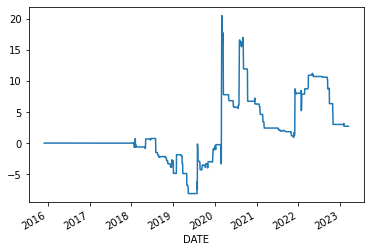

In [425]:
backtest_df.groupby('DATE')['PnL'].sum().cumsum().plot()

In [426]:
backtest_df['hour'] = backtest_df['time'].apply(lambda x: x[0:2])
backtest_df.groupby('hour')['PnL'].sum()

hour
09    -9.630625
10    -1.764522
11     3.920578
12     0.000000
13     0.000000
14    -2.225776
15    12.404051
Name: PnL, dtype: float64

In [432]:
backtest_df.groupby(['DATE', 'hour'])['PnL'].sum().sort_values()

DATE        hour
2020-03-16  09     -9.932880
2020-09-08  09     -5.040080
2020-02-28  10     -5.021357
2020-08-24  10     -4.601864
2020-03-04  09     -3.995408
                      ...   
2020-02-28  15      4.573573
2020-03-02  09      5.737992
            15      5.909036
2020-02-28  09      7.526658
2020-08-03  09      9.921693
Name: PnL, Length: 12838, dtype: float64